# Introductions / Business Problem

In this notebook I'll devise a way to find a way to devise the relationship between restaurant ratings and their location in Bangalore. I'll try to predict the value od a restaurant based on it's location , cuisine, avg price for two

# Data

I'll be using the website mapsOfIndia to get the value of all neighbourHoods in BAngalore along with their pincodes. I'll then use the FourSquare API to get the lattitudes & longitudes of the each neighbourhood then I'll use this location data to get restaurants in the Vicinity of the neighbourHood from Zomato API and map everything into one dataset so as to get meaningful insights after applying clustering algorithms

Let's get the data set for the mumbai data first

In [77]:
import requests
from lxml import html
from urllib.request import urlopen
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import folium
import json
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import pyplot as plt

In [259]:
wikiPage = urlopen('https://finkode.com/ka/bangalore.html') 
soup = BS(wikiPage,'lxml')
table = soup.find_all('table')[0]

In [260]:
dataTable = pd.DataFrame(columns=range(0,2), index = [0])

In [261]:
dataTable.columns = ['Neighborhood','PinCode']

In [262]:
rowCounter = 0
for row in table.find_all('tr'):
    columnValue = row.find_all('td')
    columncounter =0
    for column in columnValue :
        if(column.get_text() != 'Not assigned'):
            if(columncounter == 0):
                dataTable.set_value(rowCounter,'Neighborhood',column.get_text())
            elif(columncounter == 1):
                dataTable.set_value(rowCounter,'PinCode',column.get_text())
        columncounter = columncounter + 1
    rowCounter = rowCounter + 1
    

C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [263]:
dataTable.dropna(inplace = True)

In [264]:
dataTable['Neighborhood'] = dataTable['Neighborhood'].map(lambda x : x.rstrip('BHS.OGP'))

In [265]:
dataTable['Latitude'] = 0.0
dataTable['Longitude'] = 0.0

In [266]:
dataTable.head()

,Neighborhood,PinCode,Latitude,Longitude
1,A F Station Yelahanka,Bangalore,0.0,0.0
2,Adugodi,Bangalore,0.0,0.0
3,Agara,Bangalore,0.0,0.0
4,Agram,Bangalore,0.0,0.0
5,Amruthahalli,Bangalore,0.0,0.0


There we see the value of NeighbourHood name and Pincode of every neighbourhood with a default value of longitude and lattitude as 0 right now

## Let's get the long & lat for every neighbourhood

In [267]:
for neigh,index in zip(dataTable['Neighborhood'],dataTable.index):
    geolocator = Nominatim(user_agent="foursquare_agent")
    try :
        location = geolocator.geocode(neigh + ', Bangalore, India')
        dataTable.set_value(index,'Latitude',location.latitude)
        dataTable.set_value(index,'Longitude',location.longitude)
    except : 
        print(neigh)
    

A F Station Yelahanka 


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Agram 
Amruthahalli 
Anandnagar S.O (Bangalore)
Anekalbazar 
B Sk II Stage 
Bandikodigehalli 
Bangalore Bazaar 
Bangalore Corporation Building 
Bangalore Dist Offices Bldg 
Bapagrama 
Bestamaranahalli 
Bettahalsur 
Bidrahalli 
Bnagalore Viswavidalaya 
BSF Campus Yelahanka 
Chamarajasagara 
Chamrajpet S.O (Bangalore)
Chandra Lay Out 
Chikkabidarkal 
Chudenapura 
CRPF Campus Yelahanka 
Cubban Road 
Dasarahalli(Srinagar) 
Devanagundi 
Doddagubbi 
Doorvaninagar 
Dr. Ambedkar Veedhi 
Dr. Shivarama Karanth Nagar 
Fraser Town 
Gaviopuram Extension 
Gayathrinagar 
Governmemnt Electric Factory 
H.A. Farm 
H.A.L II Stage 
H.K.P. Road 
Hampinagar 
Hebbal Kempapura 
HighCourt 
Hulsur Bazaar 
Immedihalli 
Indalavadi 
Industrial Estate S.O (Bangalore)
ISRO Anthariksha Bhavan 
J.C.Nagar 
Jalavayuvihar 
Jayangar III Block 
Jeevabhimanagar 
Jeevanbhimanagar 
JP Nagar III Phase 
JP Nagar VIII phase 
K H B Colony 
Kalyananagar 
Kanteeravanagar 
Kenchanahalli 
Kugur 
Kumbalgodu Gollahalli 
Legislators Hom

In [268]:
dataTable = dataTable[(dataTable != 0).all(1)]


In [269]:
dataTable = dataTable[dataTable['Latitude'] < 13.088549 ]
dataTable = dataTable[ dataTable['Latitude'] > 12.874438 ]
dataTable = dataTable[dataTable['Longitude'] < 77.712215 ]
dataTable = dataTable[ dataTable['Longitude'] > 77.466504 ]

Let's check the number of neighbourhoods whose value existed in the system

In [270]:
dataTable.shape

(105, 4)

## Let's check the neighboudhoods placed on a map

In [271]:
dataTable.reset_index(inplace = True)

In [272]:
dataTable = dataTable.drop(['index'],axis = 1)

In [273]:
latitude = 12.9716
longitude = 77.5946

In [274]:
map_blr = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(dataTable['Latitude'], dataTable['Longitude'], dataTable['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

## Let's check the number of venues ( like bakery, pubs , restaurants etc.) for each neighbourhood

In [275]:
CLIENT_ID = 'HQADI3DUD22CJBEMCEI4MPC4PXS3SVYOJH1DYGOKQIEBPDIQ' # your Foursquare ID
CLIENT_SECRET = 'BJ4DBMDCHV40OW451L4OFEBOLX4FFNJTJHNYIMLZ2J3ZYHYV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HQADI3DUD22CJBEMCEI4MPC4PXS3SVYOJH1DYGOKQIEBPDIQ
CLIENT_SECRET:BJ4DBMDCHV40OW451L4OFEBOLX4FFNJTJHNYIMLZ2J3ZYHYV


In [276]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        LIMIT = 500
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try :
            results = requests.get(url).json()["response"]['groups'][0]['items']  
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        except :
            print('exception for : ' + name)
    
    return(nearby_venues)

In [277]:
Blr_venues = getNearbyVenues(names=dataTable['Neighborhood'],
                                   latitudes=dataTable['Latitude'],
                                   longitudes=dataTable['Longitude']
                                  )
    

Adugodi 
Arabic College 
Austin Town 
Bagalgunte 
Banashankari III Stage 
Banashankari 
Banaswadi 
Bangalore City 
Bangalore 
Bannerghatta Road 
Bannerghatta 
Basavanagudi 
Basaveshwaranagar 
Bellandur 
Benson Town 
Bilekahalli 
Byatarayanapura 
Byatarayanapura 
C.V.Raman Nagar 
Carmelaram 
Chickpet 
Chikkalasandra 
CMP Centre And School 
Deepanjalinagar 
Devasandra 
Dharmaram College 
Doddakallasandra 
Doddanekkundi 
Domlur 
G.K.V.K. 
Girinagar S.O (Bangalore)
Herohalli 
Herohalli 
Hongasandra 
Horamavu 
Hosakerehalli 
HSR Layout 
Hulimavu 
Indiranagar S.O (Bangalore)
J P Nagar 
Jakkur 
Jalahalli East 
Jalahalli 
Jalahalli West 
Jayanagar 
Jayanagar West 
K. G. Road 
Kamakshipalya 
Kanakanagar 
Kathriguppe 
Konanakunte 
Koramangala I Block 
Kothanur 
Krishnarajapuram 
Kumaraswamy Layout 
Laggere 
Lingarajapuram 
Madhavan Park 
Magadi Road 
Mahatma Gandhi Road 
Mallathahalli 
Malleswaram 
Malleswaram West 
Marathahalli Colony 
Maruthi Sevanagar 
Mathikere 
Mavalli 
Mico Layout 
Milk Co

In [278]:
dataTable.head()

,Neighborhood,PinCode,Latitude,Longitude
0,Adugodi,Bangalore,12.942847,77.610416
1,Arabic College,Bangalore,13.030013,77.620872
2,Austin Town,Bangalore,12.961274,77.615294
3,Bagalgunte,Bangalore,13.056649,77.504822
4,Banashankari III Stage,Bangalore,12.932708,77.546254


### Now that we have the data, let's check the restaurants in each neighbourhood

In [286]:
restaurants = []
for neigh,lat,long in zip(dataTable['Neighborhood'],dataTable['Latitude'],dataTable['Longitude']):
    url = 'https://developers.zomato.com/api/v2.1/search?entity_type=zone&q={}&start=1&count=20&radius=1000&sort=cost'.format(neigh)
    header = {"User-agent": "curl/7.43.0", "Accept": "application/json", "user_key": "d6fda5bb5a690e7bd41f7a5505d6e397"}
    results = requests.get(url,headers=header).json()
    restaurants.append([(
        neigh ,
        lat,
        long,
        x['restaurant']['name'],
        x['restaurant']['id'],
        x['restaurant']['cuisines'],
        x['restaurant']['average_cost_for_two'],
        x['restaurant']['user_rating']['aggregate_rating'],
        x['restaurant']['has_online_delivery'],
        x['restaurant']['has_table_booking'],results['results_found']) for x in results['restaurants']  ]
)


In [287]:
restaurants

[[],
 [('Arabic College ',
   13.0300127,
   77.6208724,
   'Caffiyana - The Brew cafe',
   '18842834',
   'North Indian',
   300,
   '3.6',
   1,
   0,
   3),
  ('Arabic College ',
   13.0300127,
   77.6208724,
   'Joginder Dhaba',
   '18845023',
   '',
   0,
   0,
   0,
   0,
   3)],
 [('Austin Town ',
   12.9612736,
   77.6152935,
   'Grand Plaza ',
   '18902147',
   'Chinese, Continental, North Indian',
   800,
   '3.4',
   1,
   0,
   90),
  ('Austin Town ',
   12.9612736,
   77.6152935,
   'Handi Punjabiyan Di',
   '18903986',
   'Chinese, North Indian',
   800,
   '3.7',
   1,
   0,
   90),
  ('Austin Town ',
   12.9612736,
   77.6152935,
   'Mughlai Rasoi',
   '18945680',
   'BBQ, North Indian',
   750,
   '3.6',
   1,
   0,
   90),
  ('Austin Town ',
   12.9612736,
   77.6152935,
   'Nagpal Chicken Corner',
   '18979397',
   'Mughlai, North Indian',
   500,
   0,
   0,
   0,
   90),
  ('Austin Town ',
   12.9612736,
   77.6152935,
   'Subway',
   '18897292',
   'Fast Food, Hea

#### Let's parse through the JSON and put the values got from Zomato to a dataFrame

In [288]:
nearby_venues = pd.DataFrame([item for restaurants in restaurants for item in restaurants])
nearby_venues.columns = ['Neighbourhood','Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                 'restaurant','restaurant id',
                  'Cuisines', 
                  'avg cost for two', 
                  'Rating', 
                  'has online delivery','has table booking',
                    'Total Rest. in area']

In [289]:
nearby_venues

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant id,Cuisines,avg cost for two,Rating,has online delivery,has table booking,Total Rest. in area
0,Arabic College,13.030013,77.620872,Caffiyana - The Brew cafe,18842834,North Indian,300,3.6,1,0,3
1,Arabic College,13.030013,77.620872,Joginder Dhaba,18845023,,0,0,0,0,3
2,Austin Town,12.961274,77.615294,Grand Plaza,18902147,"Chinese, Continental, North Indian",800,3.4,1,0,90
3,Austin Town,12.961274,77.615294,Handi Punjabiyan Di,18903986,"Chinese, North Indian",800,3.7,1,0,90
4,Austin Town,12.961274,77.615294,Mughlai Rasoi,18945680,"BBQ, North Indian",750,3.6,1,0,90
5,Austin Town,12.961274,77.615294,Nagpal Chicken Corner,18979397,"Mughlai, North Indian",500,0,0,0,90
6,Austin Town,12.961274,77.615294,Subway,18897292,"Fast Food, Healthy Food, Sandwich, Salad",500,3.8,1,0,90
7,Austin Town,12.961274,77.615294,The Amazing Wok,18899885,"Thai, Chinese",500,3.4,0,0,90
8,Austin Town,12.961274,77.615294,Lucky's Bakery & Patisserie,18918444,"Bakery, Desserts",450,3.8,1,0,90
9,Austin Town,12.961274,77.615294,Ahuja's Sweets,18944859,,400,3.7,1,0,90


In [2]:
nearby_venues = pd.read_csv(r'C:\Users\ezchave\Desktop\projects\coursera_capstone\ven',index_col = 0)

In [3]:
ratingList = nearby_venues[['Neighbourhood','restaurant','Rating']]

In [4]:
ratingList.head()

,Neighbourhood,restaurant,Rating
0,Adugodi,Cafe Noir,0.0
1,Adugodi,The Kim Chi Chef,4.0
2,Adugodi,Shiva's Bar And Restaurant,0.0
3,Adugodi,World In A Bowl,3.5
4,Adugodi,Fumes Lounge,0.0


In [134]:
# one hot encoding
Blr_ohe = pd.get_dummies(ratingList[['Rating']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Blr_ohe['Neighbourhood'] = ratingList['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [Blr_ohe.columns[-1]] + list(Blr_ohe.columns[:-1])
Blr_ohe = Blr_ohe[fixed_columns]
Blr_ohe.head()

,Neighbourhood,Rating
0,Adugodi,0.0
1,Adugodi,4.0
2,Adugodi,0.0
3,Adugodi,3.5
4,Adugodi,0.0


### Let's see the top 5 restaurants for each neighbourhood

In [136]:
num_top_venues = 5
for hood in Blr_ohe['Neighbourhood']:
    print("----"+hood+"----")
    temp = Blr_ohe[Blr_ohe['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adugodi ----


ValueError: Length mismatch: Expected axis has 21 elements, new values have 2 elements

In [5]:
nearby_venues

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant id,Cuisines,avg cost for two,Rating,has online delivery,has table booking,Total Rest. in area
0,Adugodi,12.942847,77.610416,Cafe Noir,18893963,"European, French, Salad",1500,0.0,1,0,27
1,Adugodi,12.942847,77.610416,The Kim Chi Chef,18487212,"Chinese, Thai, Momos",900,4.0,1,0,27
2,Adugodi,12.942847,77.610416,Shiva's Bar And Restaurant,18925862,"South Indian, North Indian, Fast Food",800,0.0,0,0,27
3,Adugodi,12.942847,77.610416,World In A Bowl,18672724,"Continental, North Indian, Desserts, Beverages",600,3.5,1,0,27
4,Adugodi,12.942847,77.610416,Fumes Lounge,19046495,"Continental, Chinese, North Indian",600,0.0,0,0,27
5,Adugodi,12.942847,77.610416,Punjabi Unplugged,18926792,North Indian,500,4.3,1,0,27
6,Adugodi,12.942847,77.610416,ChickenWalla,18970779,"North Indian, South Indian, Beverages, Desserts",500,0.0,1,0,27
7,Adugodi,12.942847,77.610416,Adupadi,55040,"South Indian, Chettinad",450,2.9,0,0,27
8,Adugodi,12.942847,77.610416,Vitamin Palace,18424060,"Cafe, Beverages, Fast Food, Juices",400,4.1,0,0,27
9,Adugodi,12.942847,77.610416,Bombay Sandwich Company,18684413,"Sandwich, Beverages",400,3.6,1,0,27


# Let's make the clusters now

In [8]:
# set number of clusters
kclusters = 5

grouped_clustering = Blr_ohe.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 1, 0, 1, 4, 1, 2, 4, 0])

In [10]:
Blr_ohe.head()

,Neighbourhood,Rating
0,Adugodi,0.0
1,Adugodi,4.0
2,Adugodi,0.0
3,Adugodi,3.5
4,Adugodi,0.0


In [ ]:
# add clustering labels
Blr_ohe.insert(0, 'Cluster Labels', kmeans.labels_)

data_merged = dataTable

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
data_merged = data_merged.join(Blr_ohe, on='Neighbourhood')
data_merged =  pd.merge(dataTable, Blr_ohe, how='inner', on = 'Neighborhood')


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
     
map_clusters

In [137]:
ratingList['Rating'].describe()

count    1721.000000
mean        3.583788
std         1.240353
min         0.000000
25%         3.500000
50%         4.000000
75%         4.300000
max         4.900000
Name: Rating, dtype: float64

### Let's plot the value of ratings for each neighbourhood

In [16]:
r = r.groupby('Neighbourhood').mean()

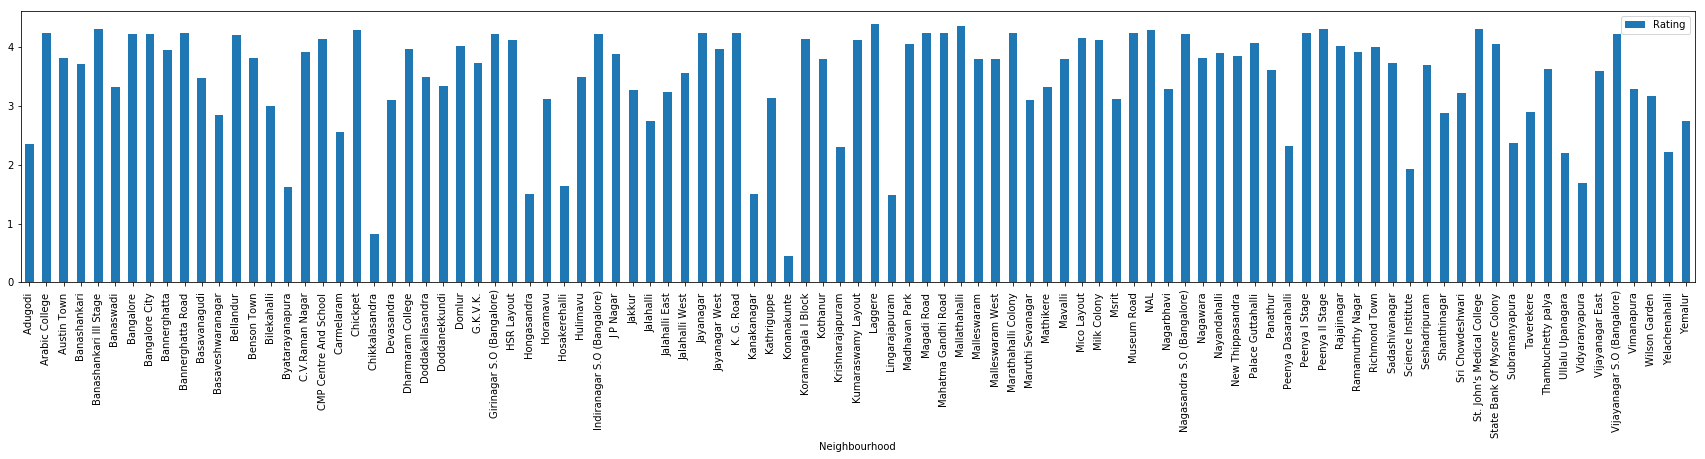

In [17]:
r.plot(kind = 'bar',figsize = (30,5))

# Let's cluster them into clusters of similar types & plot the clusters

drop the unuseful columns

In [140]:
nearby_venues.drop(['Cuisines','restaurant'],axis = 1,inplace = True)
new = nearby_venues.groupby('Neighbourhood').mean()
new.reset_index(inplace = True)
new.index = new.index + 1
new.drop('Neighbourhood',axis = 1,inplace = True)
new.drop('restaurant id',axis = 1,inplace = True)
new.drop('Total Rest. in area',axis = 1,inplace = True)
new.head()

,Neighborhood Latitude,Neighborhood Longitude,avg cost for two,Rating,has online delivery,has table booking
1,12.942847,77.610416,485.0,2.355,0.65,0.00
2,13.030013,77.620872,1575.0,4.245,0.35,0.75
3,12.961274,77.615294,1175.0,3.820,0.35,0.30
4,12.915221,77.573598,937.5,3.710,0.55,0.40
5,12.932708,77.546253,1640.0,4.310,0.40,0.70


In [126]:
X = new.values  #.astype(float)
X[0:5]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-5.91987101e-01,  3.44300649e-01, -8.19059512e-01,
        -1.26749898e+00,  1.06161062e+00, -1.17114452e+00],
       [ 1.19384191e+00,  5.45975114e-01,  1.24936832e-01,
         8.89242181e-01, -1.63515552e-01,  1.12389914e+00],
       [-2.14470772e-01,  4.38379013e-01, -2.21483845e-01,
         4.04260704e-01, -1.63515552e-01, -2.53127054e-01],
       [-1.15799116e+00, -3.65771130e-01, -4.27171121e-01,
         2.78736086e-01,  6.53235233e-01,  5.28787674e-02],
       [-7.99716965e-01, -8.93144194e-01,  1.81230192e-01,
         9.63415818e-01,  4.06721442e-02,  9.70896233e-01],
       [ 8.69091896e-01,  1.14349230e+00, -3.83868537e-01,
        -1.66305740e-01,  6.53235233e-01, -7.12135787e-01],
       [ 1.51158539e-01, -2.43715887e-02,  2.38966200e+00,
         8.77830852e-01, -1.59282942e+00,  1.27690205e+00],
       [ 1.51158539e-01, -2.43715887e-02,  2.38966200e+00,
         8.77830852e-01, -1.59282942e+00,  1.27690205e+00],
       [-8.55906796e-01,  1.56099564e-01, -1.565

In [127]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)

In [128]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [129]:
k_means_labels = k_means.labels_
k_means_labels

array([1, 0, 3, 3, 0, 3, 2, 2, 3, 2, 1, 1, 0, 3, 1, 1, 0, 0, 1, 2, 1, 1,
       3, 1, 3, 0, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 3, 3, 0, 2, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 0, 3, 0, 1, 1, 1, 0, 0, 1, 2, 0,
       1, 2, 3, 1, 3, 0, 3, 1, 0, 0, 3, 0, 0, 3, 1, 3, 1, 1, 0, 0, 1, 1,
       3, 1, 1, 1, 2, 1, 3, 1, 1])

In [130]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[1.29691682e+01, 7.75959069e+01, 1.82480769e+03, 4.13423077e+00,
        3.11538462e-01, 6.88461538e-01],
       [1.29703351e+01, 7.75896773e+01, 5.20286731e+02, 2.69930556e+00,
        5.36193380e-01, 4.93612079e-02],
       [1.29706388e+01, 7.75670909e+01, 4.10791667e+03, 4.24208333e+00,
        5.55111512e-17, 8.04166667e-01],
       [1.29793988e+01, 7.76112894e+01, 1.15055556e+03, 3.72833333e+00,
        4.30555556e-01, 4.19444444e-01]])

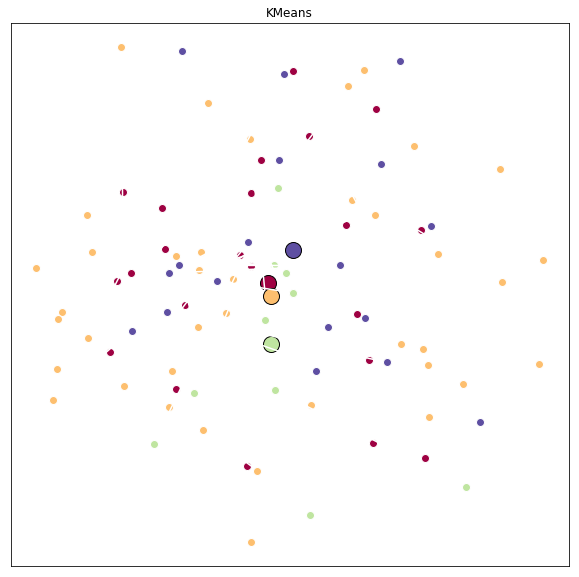

In [131]:
fig = plt.figure(figsize=(10, 10))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', markersize = 16)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=16)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()


As we can see above the data is too varied and too less to be clustered and seen good but the clusters are quite similar and no good segregation is visible

## let's try to predict the value of rating for a random new restaurant that we want to open

In [14]:
nearby_venues = pd.read_csv(r'C:\Users\ezchave\Desktop\projects\coursera_capstone\ven',index_col = 0)

In [22]:
new = nearby_venues.groupby('Neighbourhood').mean()
new.reset_index(inplace = True)
new.index = new.index + 1
#new['hood'] = new.index
new.drop('Neighbourhood',axis = 1,inplace = True)
new.drop('restaurant id',axis = 1,inplace = True)
new.drop('Total Rest. in area',axis = 1,inplace = True)
new.head()

,Neighborhood Latitude,Neighborhood Longitude,restaurant id,avg cost for two,Rating,has online delivery,has table booking,Total Rest. in area
1,12.942847,77.610416,16936179.75,485.0,2.355,0.65,0.00,27.0
2,13.030013,77.620872,8446544.30,1575.0,4.245,0.35,0.75,974.0
3,12.961274,77.615294,9276715.50,1175.0,3.820,0.35,0.30,520.0
4,12.915221,77.573598,9351196.40,937.5,3.710,0.55,0.40,377.0
5,12.932708,77.546253,11168283.60,1640.0,4.310,0.40,0.70,1820.0


### But first let's explore our data a bit

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D4D2B70>]],
      dtype=object)

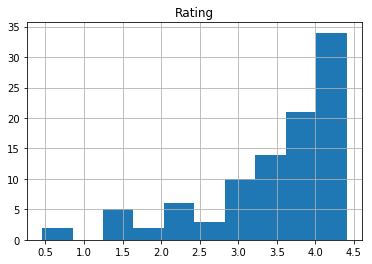

In [30]:
new.hist(column = 'Rating')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D3E4A20>]],
      dtype=object)

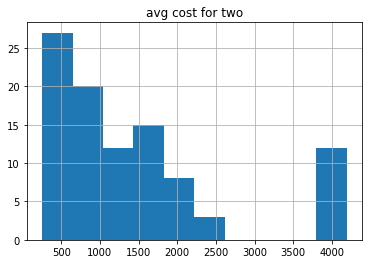

In [31]:
new.hist(column = 'avg cost for two')

In [32]:
print('Cheapest restaurant :  ' + nearby_venues['restaurant'].loc[nearby_venues['avg cost for two'].idxmin()] + ' with avg cost for two : '  + (nearby_venues['avg cost for two'].loc[nearby_venues['avg cost for two'].idxmin()]).astype(str)  + ' in ' + nearby_venues['Neighbourhood'].loc[nearby_venues['avg cost for two'].idxmin()]              )

Cheapest restaurant :  Dtink Lab with avg cost for two : 80 in Hosakerehalli 


In [33]:
print('Costliest restaurant :  ' + nearby_venues['restaurant'].loc[nearby_venues['avg cost for two'].idxmax()] + ' with avg cost for two : '  + (nearby_venues['avg cost for two'].loc[nearby_venues['avg cost for two'].idxmax()]).astype(str)       + ' in ' + nearby_venues['Neighbourhood'].loc[nearby_venues['avg cost for two'].idxmin()]                    )

Costliest restaurant :  Royal Afghan - ITC Windsor with avg cost for two : 6000 in Hosakerehalli 


In [34]:
print('Cheapest locatlity to eat out :  ' + new['Neighbourhood'].loc[new['avg cost for two'].idxmin()] + ' with avg cost for two : '  + (new['avg cost for two'].loc[new['avg cost for two'].idxmin()]).astype(str)  + ' in ' + new['Neighbourhood'].loc[new['avg cost for two'].idxmin()]              )

Cheapest locatlity to eat out :  Hosakerehalli  with avg cost for two : 253.33333333333334 in Hosakerehalli 


In [35]:
print('Costliest locatlity to eat out :  ' + new['Neighbourhood'].loc[new['avg cost for two'].idxmax()] + ' with avg cost for two : '  + (new['avg cost for two'].loc[new['avg cost for two'].idxmax()]).astype(str)  + ' in ' + new['Neighbourhood'].loc[new['avg cost for two'].idxmax()]              )

Costliest locatlity to eat out :  Bangalore  with avg cost for two : 4190.0 in Bangalore 



Now this value is for the whole Bangalore city as we also have two entries with the whole city in it

Let's continue towards predicting the value 

In [88]:
x=new.values

In [24]:
x

array([[1.29428472e+01, 7.76104155e+01, 1.69361798e+07, 4.85000000e+02,
        2.35500000e+00, 6.50000000e-01, 0.00000000e+00, 2.70000000e+01],
       [1.30300127e+01, 7.76208724e+01, 8.44654430e+06, 1.57500000e+03,
        4.24500000e+00, 3.50000000e-01, 7.50000000e-01, 9.74000000e+02],
       [1.29612736e+01, 7.76152935e+01, 9.27671550e+06, 1.17500000e+03,
        3.82000000e+00, 3.50000000e-01, 3.00000000e-01, 5.20000000e+02],
       [1.29152208e+01, 7.75735980e+01, 9.35119640e+06, 9.37500000e+02,
        3.71000000e+00, 5.50000000e-01, 4.00000000e-01, 3.77000000e+02],
       [1.29327080e+01, 7.75462535e+01, 1.11682836e+07, 1.64000000e+03,
        4.31000000e+00, 4.00000000e-01, 7.00000000e-01, 1.82000000e+03],
       [1.30141618e+01, 7.76518539e+01, 1.20990672e+07, 9.87500000e+02,
        3.32000000e+00, 5.50000000e-01, 1.50000000e-01, 3.12000000e+02],
       [1.29791198e+01, 7.75912997e+01, 1.93539495e+06, 4.19000000e+03,
        4.23500000e+00, 0.00000000e+00, 8.00000000e-01, 1.

In [89]:
y = new['Rating'].values

In [90]:
y[0:5]

array([2.355, 4.245, 3.82 , 3.71 , 4.31 ])

In [91]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (77, 6) (77,)
Test set: (20, 6) (20,)


In [92]:
X = StandardScaler().fit(x).transform(x.astype(float))
X[0:5]

array([[-0.5919871 ,  0.34430065, -0.81905951, -1.26749898,  1.06161062,
        -1.17114452],
       [ 1.19384191,  0.54597511,  0.12493683,  0.88924218, -0.16351555,
         1.12389914],
       [-0.21447077,  0.43837901, -0.22148384,  0.4042607 , -0.16351555,
        -0.25312705],
       [-1.15799116, -0.36577113, -0.42717112,  0.27873609,  0.65323523,
         0.05287877],
       [-0.79971697, -0.89314419,  0.18123019,  0.96341582,  0.04067214,
         0.97089623]])

In [93]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train.astype(int),y_train.astype(int))
        yhat=neigh.predict(X_test.astype(int))
        mean_acc[n-1] = metrics.accuracy_score(y_test.astype(int), yhat)
        std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.5 , 0.5 , 0.65, 0.6 , 0.65, 0.55, 0.75, 0.75, 0.75])

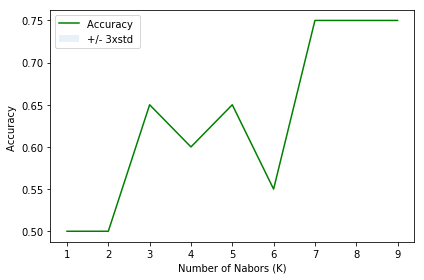

In [94]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

## So we will take the number of neighbours as 7 as the accuracy is most there

In [95]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train.astype(int),y_train.astype(int))
yhat = neigh.predict(X_test.astype(int))
yhat[0:5]

array([3, 3, 3, 4, 3])

In [96]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train.astype(int), neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test.astype(int), yhat))
f1_svm = f1_score(y_test.astype(int), yhat, average='weighted') 
jaccard_svm = jaccard_similarity_score(y_test.astype(int), yhat)
print("F1 score : " + (f1_svm).astype(str) + "\n Jaccard index : " + (jaccard_svm).astype(str))

Train set Accuracy:  0.7532467532467533
Test set Accuracy:  0.75
F1 score : 0.7497777777777777
 Jaccard index : 0.75


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### As we can see the accuracy is 0.75 for this KNN algo, let's try SVM to see if we can get better accuracy

# Support Vector Machine Classifier

In [146]:
clf = svm.SVC(kernel='poly',gamma = 0.01,C = 100)
clf.fit(X_train.astype(int), y_train.astype(int)) 
yhat_svm = clf.predict(X_test.astype(int))
print("Train set Accuracy: ", metrics.accuracy_score(y_train.astype(int), clf.predict(X_train.astype(int))))
print("Test set Accuracy: ", metrics.accuracy_score(y_test.astype(int), yhat_svm))
f1_svm = f1_score(y_test.astype(int), yhat_svm, average='weighted') 
jaccard_svm = jaccard_similarity_score(y_test.astype(int), yhat_svm)
print("F1 score : " + (f1_svm).astype(str) + "\n Jaccard index : " + (jaccard_svm).astype(str))

Train set Accuracy:  1.0
Test set Accuracy:  1.0
F1 score : 1.0
 Jaccard index : 1.0


In [124]:
X_predict = pd.DataFrame({'Neighborhood Latitiude':[12.961274], 
                  'Neighborhood Longitude':[77.615294], 
                  'avg cost for two' : [250], 
                  'Rating' : [0], 
                  'has online delivery' : [0],'has table booking':[0]})

In [125]:
yhat_svm = clf.predict(X_predict.astype(int))
yhat_svm

array([1])

In [144]:
new.corr()

,Neighborhood Latitude,Neighborhood Longitude,avg cost for two,Rating,has online delivery,has table booking
Neighborhood Latitude,1.000000,-0.030155,0.028094,0.010819,-0.118967,-0.069643
Neighborhood Longitude,-0.030155,1.000000,-0.149500,-0.018367,0.177344,-0.066721
avg cost for two,0.028094,-0.149500,1.000000,0.644483,-0.699388,0.804172
Rating,0.010819,-0.018367,0.644483,1.000000,-0.257850,0.771439
has online delivery,-0.118967,0.177344,-0.699388,-0.257850,1.000000,-0.588684
has table booking,-0.069643,-0.066721,0.804172,0.771439,-0.588684,1.000000


### So we see that the value of rating that a restaurant will get based on the location,avg cost of food , online delivery & table booking is 1.

This is the end of our analysis